In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
from ta import add_all_ta_features
from ta.utils import dropna
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt

# Download and preprocess the data
ticker = 'EURUSD=X'
data = yf.download(ticker, start='2010-01-01', end='2024-05-20')

# Ensure we are working with a copy and use all available columns
data2 = data.copy()

[*********************100%%**********************]  1 of 1 completed


In [8]:

# Drop rows with NaN values to avoid issues during feature engineering
data2.dropna(inplace=True)

# Add technical indicators
data2 = add_all_ta_features(
    data2, open="Open", high="High", low="Low", close="Close", volume="Volume", fillna=True
)

# Drop rows with NaN values after adding technical indicators
data2.dropna(inplace=True)


In [9]:
# Feature engineering: calculate return
data2['Return'] = data2['Close'].pct_change()
data2.dropna(inplace=True)

In [10]:
data2.head(1)

,Open,High,Low,Close,Adj Close,Volume,volume_adi,volume_obv,volume_cmf,volume_fi,...,momentum_ppo_signal,momentum_ppo_hist,momentum_pvo,momentum_pvo_signal,momentum_pvo_hist,momentum_kama,others_dr,others_dlr,others_cr,Return
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-04,1.431004,1.445191,1.426208,1.442398,1.442398,0,0.0,0,0.0,0.0,...,0.003773,0.015094,0.0,0.0,0.0,1.440585,0.236556,0.236276,0.236556,0.002366


In [11]:
# Select features for the model
features = ['Close', 'volume_adi', 'volume_obv', 'volume_cmf', 'volume_fi', 'volatility_bbm',
            'volatility_bbh', 'volatility_bbl', 'volatility_kcc', 'volatility_kch', 'volatility_kcl',
            'trend_macd', 'trend_macd_signal', 'trend_macd_diff', 'trend_ema_fast', 'trend_ema_slow',
            'momentum_rsi', 'momentum_stoch_rsi']

data2 = data2[features]

In [12]:
# Normalize the data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data2)

sequence_length = 60
X, y = [], []
for i in range(sequence_length, len(data_scaled)):
    X.append(data_scaled[i-sequence_length:i])
    y.append(data_scaled[i, 0])
X, y = np.array(X), np.array(y)

2948

In [13]:
# Split the data
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [14]:
# Build the LSTM model with more layers and dropout
model = Sequential()
model.add(Input(shape=(X.shape[1], X.shape[2])))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=100, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(units=1))


model.compile(optimizer='adam', loss='mean_squared_error')

In [15]:
# Early stopping and learning rate scheduler
early_stop = EarlyStopping(monitor='val_loss', patience=10)
lr_scheduler = LearningRateScheduler(lambda epoch: 1e-4 * 10**(epoch / 20))

In [20]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2,
                    callbacks=[early_stop, lr_scheduler])

Epoch 1/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 181ms/step - loss: 0.1063 - val_loss: 8.2709e-04 - learning_rate: 1.0000e-04
Epoch 2/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 14s 187ms/step - loss: 0.0071 - val_loss: 7.5902e-04 - learning_rate: 1.1220e-04
Epoch 3/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 186ms/step - loss: 0.0056 - val_loss: 5.7488e-04 - learning_rate: 1.2589e-04
Epoch 4/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 234ms/step - loss: 0.0045 - val_loss: 4.6307e-04 - learning_rate: 1.4125e-04
Epoch 5/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 229ms/step - loss: 0.0046 - val_loss: 4.3562e-04 - learning_rate: 1.5849e-04
Epoch 6/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 18s 202ms/step - loss: 0.0044 - val_loss: 3.9945e-04 - learning_rate: 1.7783e-04
Epoch 7/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 20s 196ms/step - loss: 0.0038 - val_loss: 6.4456e-04 - learning_rate: 1.9953e-04
Epoch 8/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 17s 152ms/step - loss: 0.0036 - val_loss: 4.6376e-04 - learning_rate: 2.2387e-04
Epoch 9/100
74/74 ━━━━━━━━━━━━━━━━━━━━ 1

In [33]:
# Save the model to a file
model.save('eur_usd_lstm_model.h5')

24/24 ━━━━━━━━━━━━━━━━━━━━ 3s 121ms/step


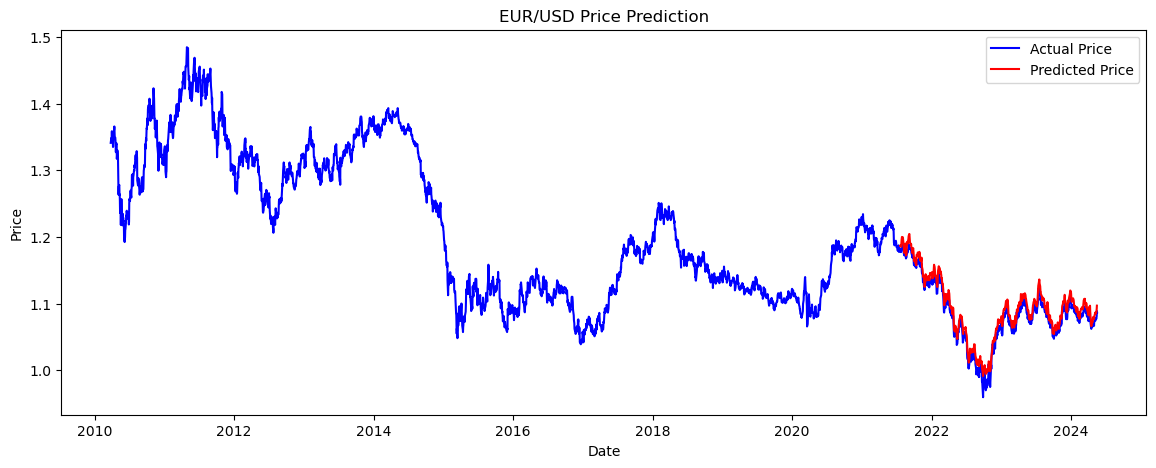

In [21]:
# Predict and visualize
predictions = model.predict(X_test)

# We only need to inverse transform the 'Close' predictions, not all features
close_scaler = MinMaxScaler()
close_scaler.fit(data2[['Close']])
predictions = close_scaler.inverse_transform(predictions)

# Adjust indices for plotting
train_data_len = split + sequence_length
test_data_index = data.index[train_data_len:train_data_len + len(predictions)]

plt.figure(figsize=(14, 5))
plt.plot(data.index[sequence_length:], data['Close'][sequence_length:], color='blue', label='Actual Price')
plt.plot(test_data_index, predictions, color='red', label='Predicted Price')
plt.title('EUR/USD Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [32]:

# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_test_actual = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

Mean Squared Error: 0.000140355816188562
Mean Absolute Error: 0.010244577759156557
R-squared: 0.9380826278106382


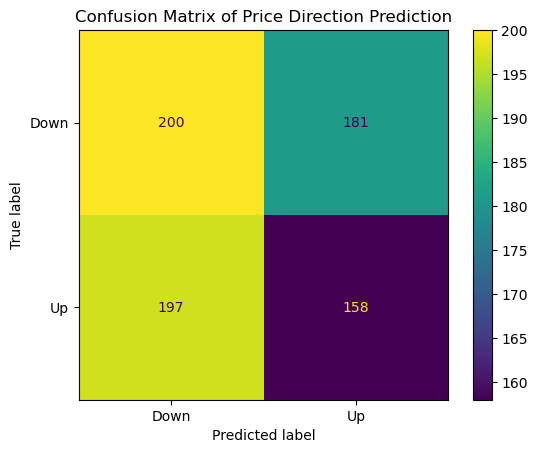

In [35]:



# Confusion matrix for direction prediction
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Determine the direction of the price movement
y_test_direction = np.diff(y_test_actual, axis=0).reshape(-1)
predictions_direction = np.diff(predictions, axis=0).reshape(-1)

# Convert to binary classification: 1 for up, 0 for down
y_test_binary = (y_test_direction > 0).astype(int)
predictions_binary = (predictions_direction > 0).astype(int)

# Calculate confusion matrix
cm = confusion_matrix(y_test_binary, predictions_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down', 'Up'])
disp.plot()

plt.title('Confusion Matrix of Price Direction Prediction')
plt.show()


In [36]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import numpy as np

y_test_actual = close_scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate metrics
mse = mean_squared_error(y_test_actual, predictions)
mae = mean_absolute_error(y_test_actual, predictions)
r2 = r2_score(y_test_actual, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'R-squared: {r2}')

# Calculate residuals
residuals = y_test_actual - predictions

# Calculate standard deviation of residuals
std_dev_residuals = np.std(residuals)
print(f'Standard Deviation of Residuals: {std_dev_residuals}')


Mean Squared Error: 0.000140355816188562
Mean Absolute Error: 0.010244577759156557
R-squared: 0.9380826278106382
Standard Deviation of Residuals: 0.00654179110248781
